In [1]:
import numpy as np
from pathlib import Path
from production import Problem, ExactSolver
from production.utils import get_mean_err
import matplotlib.pyplot as plt
import pickle

In [2]:
plus_experiment_path = Path("../data/loop_J_x_J_z_T_m")
minus_experiment_path = Path("../data/loop-J-x-J-z-T-m")

In [3]:
plus_energies = np.load(plus_experiment_path / "energies.npy")[0:4, :, :]
with open(plus_experiment_path / "spins.pickle", "rb") as f:
    plus_spins = pickle.load(f)[0:4]
minus_energies = np.load(minus_experiment_path / "energies.npy")[0:4, :, :]
with open(minus_experiment_path / "spins.pickle", "rb") as f:
    minus_spins = pickle.load(f)[0:4]

In [4]:
ns = [4, 6, 8, 10]
plus_problems = [Problem(n_sites=n, J_x=2.2, J_z=1.0, temperature=1.0, m=6) for n in ns]
minus_problems =  [Problem(n_sites=n, J_x=2.2, J_z=-1.0, temperature=1.0, m=6) for n in ns]

In [5]:
exact_plus_energies = []
exact_minus_energies = []
for i in range(3):
    n = ns[i]
    plus_pb = plus_problems[i]
    minus_pb = minus_problems[i]
    plus_solver = ExactSolver(plus_pb)
    exact_plus_energies.append(plus_solver.energy.real)
    minus_solver = ExactSolver(minus_pb)
    exact_minus_energies.append(minus_solver.energy.real)


In [6]:
mean_plus_energies, err_plus_energies = get_mean_err(plus_energies)
mean_minus_energies, err_minus_energies = get_mean_err(minus_energies)

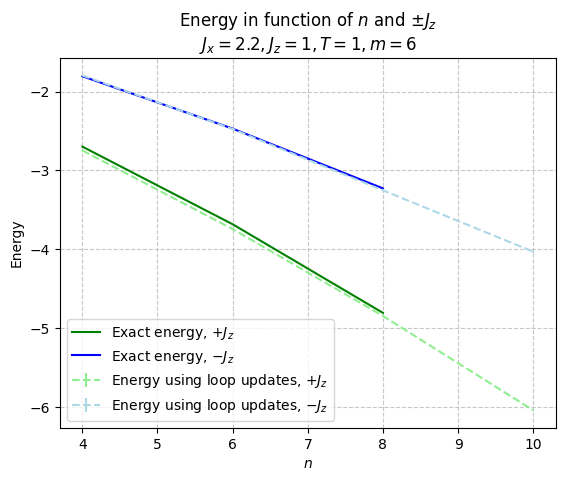

In [97]:
fig, ax = plt.subplots()
ax.set_title(r"Energy in function of $n$ and $\pm J_z$"
             "\n"
             r"$J_x=2.2, J_z=1, T=1, m=6$")
ax.plot(ns[0:3], exact_plus_energies, label="Exact energy, $+J_z$", color="green")
ax.errorbar(ns, mean_plus_energies, err_plus_energies, linestyle="dashed", label="Energy using loop updates, $+J_z$", color="lightgreen")
ax.plot(ns[0:3], exact_minus_energies, label="Exact energy, $-J_z$", color="blue")
ax.errorbar(ns, mean_minus_energies, err_minus_energies, linestyle="dashed", label="Energy using loop updates, $-J_z$", color="lightblue")
ax.set_xlabel("$n$")
ax.set_ylabel("Energy")
ax.legend(loc="lower left")
ax.grid(linestyle='--', alpha=0.7)
fig.savefig(Path("../figures/energies_n.pdf"))
plt.show()

In [55]:
n = 8
i = np.where(np.array(ns) == n)[0][0]
max_d = (n // 2) + 1

In [88]:
plus_ten_spins = (np.mean(plus_spins[i], axis=1).T)[:max_d, :]
# (d, n_rep)
mean_plus_ten_spins = np.mean(plus_ten_spins, axis=1)
err_plus_ten_spins = np.std(plus_ten_spins, axis=1) / np.sqrt(plus_ten_spins.shape[1])

minus_ten_spins = (np.mean(minus_spins[i], axis=1).T)[:max_d, :]
mean_minus_ten_spins = np.mean(minus_ten_spins, axis=1)
err_minus_ten_spins = np.std(minus_ten_spins, axis=1) / np.sqrt(plus_ten_spins.shape[1])


In [89]:
def get_SS_d(pb: Problem,i: int, d: int):
    n = pb.n_sites
    ops = [np.eye(2, dtype="complex128") for _ in range(n)]
    ops[i] = 0.5 * np.array([[1, 0], [0, -1]], dtype="complex128")
    ops[(i + d) % n] = 0.5 * np.array([[1, 0], [0, -1]], dtype="complex128")
    S = ops[0]
    for op in ops[1:]:
        S = np.kron(S, op)
    return S

In [90]:
minus_pb = minus_problems[i]
plus_pb = plus_problems[i]
minus_solver = ExactSolver(minus_pb)
plus_solver = ExactSolver(plus_pb)
exact_plus_spins = []
exact_minus_spins = []
for d in range(1, max_d+1):
    exact_minus_spins.append(
        minus_solver.compute(get_SS_d(minus_pb, 0, d)).real
    )
    exact_plus_spins.append(
        plus_solver.compute(get_SS_d(plus_pb, 0, d)).real
    )

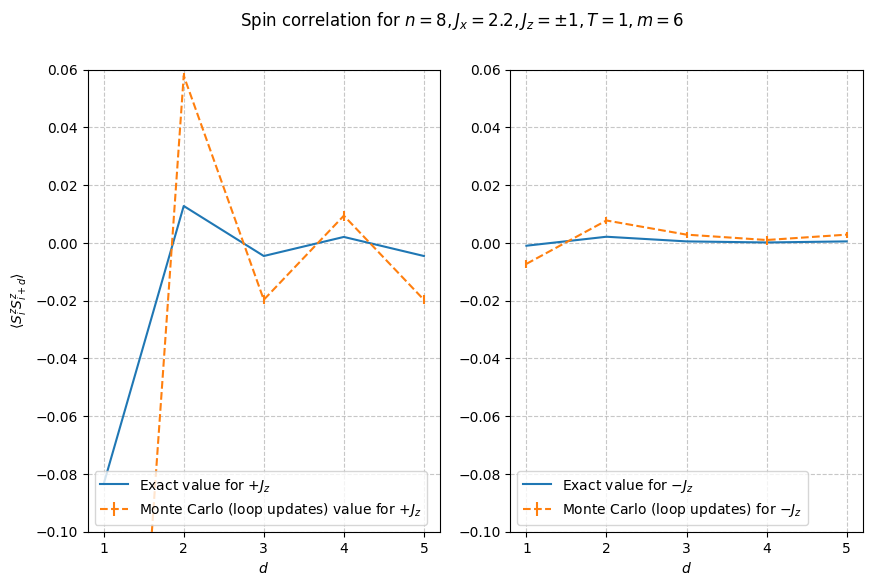

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

fig.suptitle(f"Spin correlation for $n={n}, J_x=2.2, J_z=\\pm1, T=1, m=6$")

ds = range(1, max_d+1)

ax1.plot(ds, exact_plus_spins, label="Exact value for $+J_z$")
ax2.plot(ds, exact_minus_spins,  label="Exact value for $-J_z$")
ax1.errorbar(ds, mean_plus_ten_spins, err_plus_ten_spins, linestyle="dashed",  label="Monte Carlo (loop updates) value for $+J_z$")
ax2.errorbar(ds, mean_minus_ten_spins, err_minus_ten_spins, linestyle="dashed",  label="Monte Carlo (loop updates) for $-J_z$")

ax1.set_ylabel(r"$\langle S^z_iS^z_{i+d} \rangle$")

ax1.set_ylim(-0.1, 0.06)
ax2.set_ylim(-0.1, 0.06)

ax1.set_xlabel("$d$")
ax1.set_xticks(ds)
ax2.set_xlabel("$d$")
ax2.set_xticks(ds)

ax1.legend(loc="lower left")
ax1.grid(linestyle='--', alpha=0.7)
ax2.legend(loc="lower left")
ax2.grid(linestyle='--', alpha=0.7)

fig.savefig(Path("../figures/spin_correlation.pdf"))
plt.show()